In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm,rc,animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

In [133]:
class SN:
    def __init__(self,w_init,b_init,algo):
        self.w=w_init
        self.b=b_init
        self.w_h=[]
        self.b_h=[]
        self.e_h=[]
        self.algo=algo
        
    def sigmoid(self,x,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        return (1.0/(1.0+(np.exp(-(w*x+b)))))
    
    def error(self,X,Y,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        err=0
        for x,y in zip(X,Y):
            err+=(0.5*((self.sigmoid(x,w,b)-y)**2))
            
        return err
    
    def grad_w(self,x,y,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        y_pred=self.sigmoid(x,w,b)
        return (y_pred-y)*y_pred*(1-y_pred)*x
    
    def grad_b(self,x,y,w=None,b=None):
        if w is None:
            w=self.w
        if b is None:
            b=self.b
        y_pred=self.sigmoid(x,w,b)
        return (y_pred-y)*y_pred*(1-y_pred)
    
    
    
    def fit(self,X,Y,epochs=100,eta=0.01,
            gamma=0.9,mini_batch_size=100
           ,eps=1e-8,beta=0.9,beta1=0.9,beta2=0.9):
        
        self.w_h=[]
        self.b_h=[]
        self.e_h=[]
        self.X=X
        self.Y=Y
        
        if self.algo == 'GD':
            for i in range(epochs):
                dw=0
                db=0
                for x,y in zip(X,Y):
                    db+=self.grad_b(x,y)
                    dw+=self.grad_w(x,y)
                self.w-=(eta*dw)/X.shape[0]
                self.b-=(eta*db)/X.shape[0]
                
                self.append_log()
                
        elif self.algo=='MiniBatch':
             for i in range(epochs):
                dw=0
                db=0
                points_seen=0
                for x,y in zip(X,Y):
                    db+=self.grad_b(x,y)
                    dw+=self.grad_w(x,y)
                    points_seen+=1
                    if points_seen % mini_batch_size == 0:
                        
                        self.w-=(eta*dw)/mini_batch_size
                        self.b-=(eta*db)/mini_batch_size
                        self.append_log()
                        dw,db=0,0


                
         
                
                
               
                        
               
            
                
        elif self.algo=='Momentum':
                v_w,v_b=0,0
                for i in range(epochs):
                    dw,db=0,0

                    for x,y in zip(X,Y):
                        db+=self.grad_b(x,y)
                        dw+=self.grad_w(x,y)
                    v_w=gamma*v_w+eta*dw #self.w-=(eta*dw)/X.shape[0]
                    v_b=gamma*v_b+eta*db #self.b-=(eta*db)/X.shape[0]
                    self.w = self.w - v_w
                    self.b = self.b- v_b
                    
                    self.append_log()
                    
        elif self.algo=='NAG':
                v_w,v_b=0,0
                for i in range(epochs):
                    dw,db=0,0
                    v_w = gamma*v_w
                    v_b = gamma*v_b
                    for x,y in zip(X,Y):
                        
                        db+=self.grad_b(x,y,self.w-v_w,self.b-v_b)
                        dw+=self.grad_w(x,y,self.w-v_w,self.b-v_b)
                        
                    v_w+=eta*dw #gamma*v_w+eta*dw #self.w-=(eta*dw)/X.shape[0]
                    v_b+=eta*db #gamma*v_b+eta*db #self.b-=(eta*db)/X.shape[0]
                    self.w = self.w - v_w
                    self.b = self.b- v_b
                    
                    self.append_log()
                    
        elif self.algo=='AdaGrad':
            
            v_w,v_b=0,0
            for i in range(epochs):
                dw,db=0,0
                for x,y in zip(X,Y):
                    db+=self.grad_b(x,y)
                    dw+=self.grad_w(x,y)
                v_w+= dw**2
                v_b+=db**2
                self.w -= ((eta/(np.sqrt(v_w)+eps))*dw)
                self.b -= ((eta/(np.sqrt(v_b)+eps))*db)

                self.append_log()
                
            
        elif self.algo=='RMSProp':
            
            v_w,v_b=0,0
            for i in range(epochs):
                dw,db=0,0
                for x,y in zip(X,Y):
                    db+=self.grad_b(x,y)
                    dw+=self.grad_w(x,y)
                v_w+= beta*v_w+(1-beta)*(dw**2)
                v_b+= beta*v_b+(1-beta)*(db**2)
                self.w -= ((eta/(np.sqrt(v_w)+eps))*dw)
                self.b -= ((eta/(np.sqrt(v_b)+eps))*db)

                self.append_log()
                
        elif self.algo=='Adam':
            v_w,v_b=0,0
            m_w,m_b=0,0
            num_updates=0
            for i in range(epochs):
                dw,db=0,0
                for x,y in zip(X,Y):
                    db+=self.grad_b(x,y)
                    dw+=self.grad_w(x,y)
                    num_updates+=1
                    m_w = beta1* m_w + (1-beta1)*dw
                    m_b = beta1* m_b + (1-beta1)*db
                    v_w+= beta2*v_w+((1-beta2)*(dw**2))
                    v_b+= beta2*v_b+((1-beta2)*(db**2))
                    m_w_c = m_w/(1-np.power(beta1,num_updates))
                    m_b_c = m_b/(1-np.power(beta1,num_updates))
                    v_w_c = v_w/(1-np.power(beta2,num_updates))
                    v_b_c = v_b/(1-np.power(beta2,num_updates))
                    self.w -= ((eta/(np.sqrt(v_w_c)+eps))*m_w_c)
                    self.b -= ((eta/(np.sqrt(v_b_c)+eps))*m_b_c)

                    self.append_log()


                    
                
                
                




            


         
            
        
            
        
    def append_log(self):
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(self.X,self.Y))
                
            
        
    
        

In [134]:
#config
X=np.asarray([3.5,0.35,3.2,-2.0,1.5,-0.5])
Y=np.asarray([0.5,0.50,0.5,0.5,0.1,0.3])

algo='Adam'

w_init=-2
b_init=-2

epochs=1000
eta=0.1

w_min=-7
w_max=5

b_min=-5
b_max=5

animation_frames=20
plot_3d=True
plot_2d=True

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: overflow encountered in double_scalars


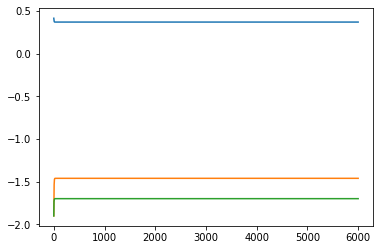

In [135]:
sn=SN(w_init,b_init,algo)
sn.fit(X,Y,epochs=epochs,eta=eta)
plt.plot(sn.e_h)
plt.plot(sn.w_h)
plt.plot(sn.b_h)
plt.show()

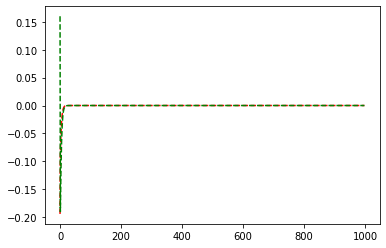

In [122]:
w_diff = [t-s for t,s in zip(sn.w_h,sn.w_h[1:]) ]
b_diff = [t-s for t,s in zip(sn.b_h,sn.b_h[1:]) ]
plt.plot(w_diff,'r--')
plt.plot(b_diff,'g--')



In [123]:
W=np.linspace(w_min,w_max,256)
B=np.linspace(b_min,b_max,256)
WW,BB=np.meshgrid(W,B)
Z=sn.error(X,Y,WW,BB)

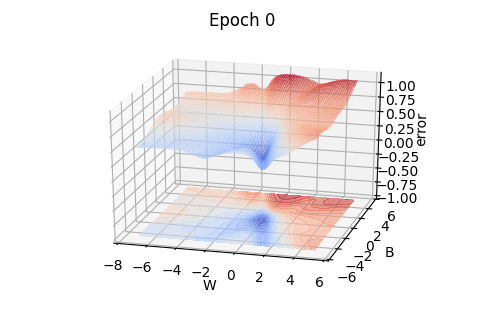

In [124]:
if plot_3d:
    fig = plt.figure(dpi=100)
    ax=fig.gca(projection='3d')
    surf = ax.plot_surface(WW,BB,Z,rstride=3,cstride=3,alpha=0.3,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    cset=ax.contourf(WW,BB,Z,25,alpha=0.6,offset=-1,cmap=cm.coolwarm,zdir='z')
    ax.set_xlabel('W')
    ax.set_xlim(w_min-1,w_max+1)
    ax.set_ylabel('B')
    ax.set_ylim(b_min-1,b_max+1)
    ax.set_zlabel('error')
    ax.set_zlim(-1,np.max(Z))
    ax.view_init(elev=25,azim=-75)
    ax.dist=12
    title=ax.set_title('Epoch 0')

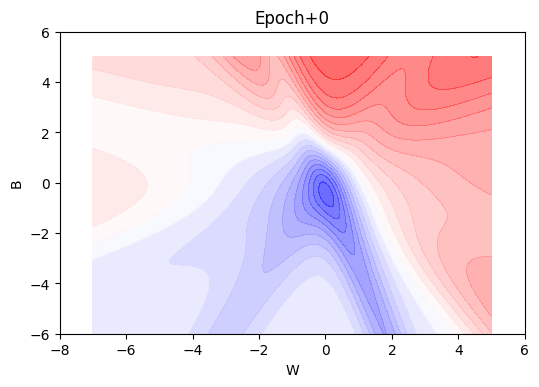

In [125]:
if plot_2d:
    W=np.linspace(w_min,w_max,256)
    B=np.linspace(w_min,w_max,256)
    WW,BB = np.meshgrid(W,B)
    Z=sn.error(X,Y,WW,BB)
    
    fig = plt.figure(dpi=100)
    ax=plt.subplot(111)
    ax.set_xlabel('W')
    ax.set_xlim(w_min-1,w_max+1)
    ax.set_ylabel('B')
    ax.set_ylim(b_min-1,b_max+1)
    title = ax.set_title('Epoch+0')
    cset=plt.contourf(WW,BB,Z,25,cmap=cm.bwr,alpha=0.6)
    plt.show()
    

In [126]:
def plot_animate_2d(i):
    i=int(i*(epochs/animation_frames))
    line.set_data(sn.w_h[:i+1],sn.b_h[:i+1])
    title.set_text('epoch: {},error: {}'.format(i,sn.e_h[i+1]))
    return line,title

In [127]:
if plot_2d:
    i=0
    line, =ax.plot(sn.w_h[:i+1],sn.b_h[:i+1],color='black',marker='.')
    anim=animation.FuncAnimation(fig,func=plot_animate_2d,frames=animation_frames)

In [128]:
anim

In [29]:
def plot_animate_3d(i):
    i = int(i*(epochs/animation_frames))
    line1.set_data(sn.w_h[:i+1],sn.b_h[:i+1])
    line1.set_3d_properties(sn.e_h[:i+1])
    line2.set_data(sn.w_h[:i+1],sn.b_h[:i+1])
    line2.set_3d_properties(np.zeros(i+1)-1)
    title.set_text('Epoch: {}, error: {}'.format(i,sn.e_h[i]))
    return line1,line2,title
    

In [30]:
if plot_3d:
    i=0
    line1,=ax.plot(sn.w_h[:i+1],sn.b_h[:i+1],sn.e_h[:i+1],color='black',marker='.')
    line2,=ax.plot(sn.w_h[:i+1],sn.b_h[:i+1],np.zeros(i+1)-1,color='red',
                         marker='.')
    anim=animation.FuncAnimation(fig,func=plot_animate_3d,
                                frames=animation_frames)
    rc('animation',html='jshtml')
    anim

In [31]:
anim